In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [8]:
# Daten aus EDA importieren
df = pd.read_csv("inventory_data.csv")
print(df.dtypes)
df.head()

Unnamed: 0                       int64
product_id                       int64
warehouse_inventory            float64
inventory_date                  object
inventory_cost_per_unit        float64
absolute_inventory_cost        float64
year                             int64
month                            int64
order_quantity                 float64
profit                         float64
gross_sales                    float64
average_discount_percentage    float64
average_fulfillment_days       float64
dtype: object


,Unnamed: 0,product_id,warehouse_inventory,inventory_date,inventory_cost_per_unit,absolute_inventory_cost,year,month,order_quantity,profit,gross_sales,average_discount_percentage,average_fulfillment_days
0,0,1,254.0,2015-01-01,0.49,124.46,2015,1,456.0,22197.0,27360.0,0.099470,103.3444
1,1,1,675.0,2015-02-01,0.48,324.00,2015,2,378.0,17640.0,22680.0,0.106333,70.7667
2,2,1,542.0,2015-03-01,1.46,791.32,2015,3,442.0,20580.0,26520.0,0.091571,78.7143
3,3,1,633.0,2015-04-01,1.23,778.59,2015,4,403.0,19698.0,24180.0,0.107463,83.2313
4,4,1,624.0,2015-05-01,0.73,455.52,2015,5,330.0,16023.0,19800.0,0.103211,55.9450


In [9]:
# DataFrame umformatieren
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("absolute_inventory_cost", axis=1, inplace=True)
df['inventory_date'] = pd.to_datetime(df["inventory_date"])
df.set_index('inventory_date', inplace=True)
df.head()


,product_id,warehouse_inventory,inventory_cost_per_unit,year,month,order_quantity,profit,gross_sales,average_discount_percentage,average_fulfillment_days
inventory_date,,,,,,,,,,
2015-01-01,1,254.0,0.49,2015,1,456.0,22197.0,27360.0,0.099470,103.3444
2015-02-01,1,675.0,0.48,2015,2,378.0,17640.0,22680.0,0.106333,70.7667
2015-03-01,1,542.0,1.46,2015,3,442.0,20580.0,26520.0,0.091571,78.7143
2015-04-01,1,633.0,1.23,2015,4,403.0,19698.0,24180.0,0.107463,83.2313
2015-05-01,1,624.0,0.73,2015,5,330.0,16023.0,19800.0,0.103211,55.9450


In [10]:
# Filtern des Trainingssets (2015 und 2016)

# Filtern des Trainingssets (2015, 2016 und das erste halbe Jahr von 2017)
train_set = df[(df.index.year == 2015) | (df.index.year == 2016) | ((df.index.year == 2017) & (df.index.month <= 6))]

# Filtern des Testsets (das zweite halbe Jahr von 2017)
test_set = df[((df.index.year == 2017) & (df.index.month > 6))]


# Überprüfen Sie die Anzahl der Datensätze im Trainings- und Testset
print("Anzahl der Datensätze im Trainingsset:", len(train_set))
print("Anzahl der Datensätze im Testset:", len(test_set))

Anzahl der Datensätze im Trainingsset: 3492
Anzahl der Datensätze im Testset: 708


In [11]:
# Aufteilen in abhängige und unabhängige Variable

X_train = train_set.drop("warehouse_inventory", axis=1)
y_train = train_set["warehouse_inventory"]

X_test = test_set.drop("warehouse_inventory", axis=1)  # Unabhängige Variablen des Testsets
y_test = test_set["warehouse_inventory"]  # Abhängige Variable des Testsets

In [17]:
# Definition des Parameterraums für die Grid-Suche mit den neuen Parametern und verkleinerten Parameterräumen
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
}

# Initialisierung des XGBoost-Modells
model = XGBRegressor()

# Durchführung der Grid-Suche
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Beste Parameter:", grid_search.best_params_)

# Vorhersagen für Testdaten mit den besten Parametern
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Auswertung des Modells
r2 = r2_score(y_test, y_pred)
print("R2-Score:", r2)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=200; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=200; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=200; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=300; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=300; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=300; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=400; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=400; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=1, n

In [18]:
# XGBoost-Modell erstellen und trainieren
model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=600)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# Modell evaluieren

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2-Score:", r2)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R^2-Score: 0.5655502189888626
Mean Squared Error: 1108.5169488685926


In [20]:
best_model = grid_search.best_estimator_

# Feature-Importances ausgeben
print("Feature-Importances:")
for feature, importance in zip(X_train.columns, best_model.feature_importances_):
    print(f"{feature}: {importance}")

Feature-Importances:
product_id: 0.13365095853805542
inventory_cost_per_unit: 0.029235433787107468
year: 0.12152992933988571
month: 0.05464122071862221
order_quantity: 0.3889181315898895
profit: 0.06768476217985153
gross_sales: 0.05583743378520012
average_discount_percentage: 0.08208448439836502
average_fulfillment_days: 0.06641768664121628


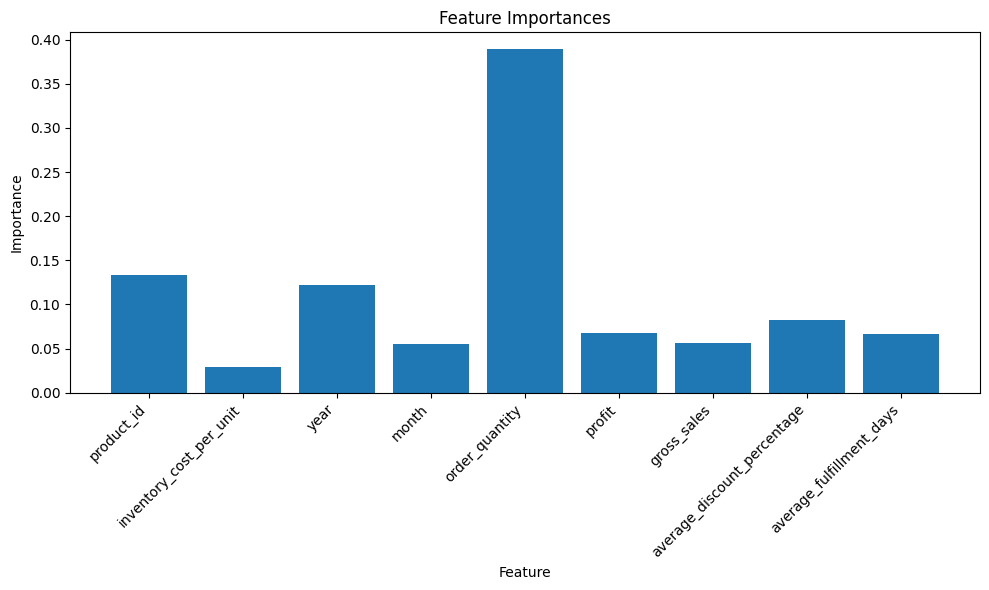

In [21]:
# Feature-Importances ausgeben
feature_importances = best_model.feature_importances_
features = X_train.columns


# Säulendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()